In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def unwrap_CPUs(df):
    new_df = df.copy()
    for i in range(16):
        col_name = "CPU{}".format(i)
        new_df[col_name] = df["CPU"].apply(lambda x: x[i])
    return new_df

In [113]:
# Read data from files
gazebo_static = pd.read_csv("data/Gazebo/static_test.csv")
gazebo_static_fps = pd.read_csv("data/Gazebo/static_gazebo_fps.csv")
gazebo_dynamic = pd.read_csv("data/Gazebo/dynamic_test.csv")
gazebo_dynamic_fps = pd.read_csv("data/Gazebo/dynamic_gazebo_fps.csv")

# Drop first entry for every experiment (incorrect RTF)
gazebo_static = gazebo_static.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)
gazebo_dynamic = gazebo_dynamic.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)

# Convert CPU readings to lists of floats
gazebo_static["CPU"] = gazebo_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
gazebo_dynamic["CPU"] = gazebo_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
gazebo_static["CPU_ALL"] = gazebo_static["CPU"].apply(lambda x: np.mean(x))
gazebo_dynamic["CPU_ALL"] = gazebo_dynamic["CPU"].apply(lambda x: np.mean(x))

# Duplicate data for static scene in dynamic tests
tmp_rows = gazebo_static[gazebo_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
gazebo_dynamic = pd.concat([tmp_rows, gazebo_dynamic], axis=0).reset_index(drop=True)

# Create average of all readings where possible
gazebo_static_tmp = gazebo_static.groupby(["test", "count"]).agg("mean").reset_index()
gazebo_dynamic_tmp = gazebo_dynamic.groupby(["test", "count"]).agg("mean").reset_index()

gazebo_static_tmp["FPS"] = gazebo_static_fps["FPS"]
gazebo_static_tmp["CPU"] = gazebo_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_static = gazebo_static_tmp

gazebo_dynamic_tmp["FPS"] = gazebo_dynamic_fps["FPS"]
gazebo_dynamic_tmp["CPU"] = gazebo_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_dynamic = gazebo_dynamic_tmp

gazebo_tests = pd.concat([gazebo_static, gazebo_dynamic])
gazebo_tests["RAM_USED"] = gazebo_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)
gazebo_tests["FPS_SCALED"] = gazebo_tests["FPS"]*gazebo_tests["RTF"]

# Final dataframes
gazebo_static = gazebo_tests[gazebo_tests["test"] == "static"]
gazebo_dynamic = gazebo_tests[gazebo_tests["test"] == "dynamic"]

# Unwrap CPU list to separate columns
gazebo_static = unwrap_CPUs(gazebo_static)
gazebo_dynamic = unwrap_CPUs(gazebo_dynamic)

In [150]:
# Read data from files
unity_static = pd.read_csv("data/Unity/static_test.csv")
unity_static_fps = pd.read_csv("data/Unity/static_unity_linux_fps.csv")
unity_dynamic = pd.read_csv("data/Unity/dynamic_test.csv")
unity_dynamic_fps = pd.read_csv("data/Unity/dynamic_unity_linux_fps.csv")
unity_dynamic_slowed = pd.read_csv("data/Unity/dynamic_test_slowed.csv")
unity_dynamic_slowed_fps = pd.read_csv("data/Unity/dynamic_slowed_unity_linux_fps.csv")

# Convert CPU readings to lists of floats
unity_static["CPU"] = unity_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_dynamic["CPU"] = unity_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_dynamic_slowed["CPU"] = unity_dynamic_slowed["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
unity_static["CPU_ALL"] = unity_static["CPU"].apply(lambda x: np.mean(x))
unity_dynamic["CPU_ALL"] = unity_dynamic["CPU"].apply(lambda x: np.mean(x))
unity_dynamic_slowed["CPU_ALL"] = unity_dynamic_slowed["CPU"].apply(lambda x: np.mean(x))

# Duplicate data for static scene in dynamic tests
tmp_rows = unity_static[unity_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
unity_dynamic = pd.concat([tmp_rows, unity_dynamic], axis=0).reset_index(drop=True)
unity_dynamic_slowed = pd.concat([tmp_rows.copy(), unity_dynamic_slowed], axis=0).reset_index(drop=True)
unity_dynamic_slowed["test"] = "dynamic_slowed"

# Create average of all readings where possible
unity_static_tmp = unity_static.groupby(["test", "count"]).agg("mean").reset_index()
unity_dynamic_tmp = unity_dynamic.groupby(["test", "count"]).agg("mean").reset_index()
unity_dynamic_slowed_tmp = unity_dynamic_slowed.groupby(["test", "count"]).agg("mean").reset_index()

unity_static_tmp["FPS"] = unity_static_fps["FPS"]
unity_static_tmp["CPU"] = unity_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_static = unity_static_tmp

unity_dynamic_tmp["FPS"] = unity_dynamic_fps["FPS"]
unity_dynamic_tmp["CPU"] = unity_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_dynamic = unity_dynamic_tmp

unity_dynamic_slowed_tmp["FPS"] = unity_dynamic_slowed_fps["FPS"]
unity_dynamic_slowed_tmp["CPU"] = unity_dynamic_slowed[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_dynamic_slowed = unity_dynamic_slowed_tmp

unity_tests = pd.concat([unity_static, unity_dynamic, unity_dynamic_slowed])
unity_tests["RAM_USED"] = unity_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)

# Final dataframes
unity_static = unity_tests[unity_tests["test"] == "static"]
unity_dynamic = unity_tests[unity_tests["test"] == "dynamic"]
unity_dynamic_slowed = unity_tests[unity_tests["test"] == "dynamic_slowed"]

# Unwrap CPU list to separate columns
unity_static = unwrap_CPUs(unity_static)
unity_dynamic = unwrap_CPUs(unity_dynamic)
unity_dynamic_slowed = unwrap_CPUs(unity_dynamic_slowed)

unity_dynamic_slowed["FPS"] = unity_dynamic_slowed["FPS"] * gazebo_dynamic["RTF"]  # Becuase the FPS counter was measuring incorrect data

In [115]:
# Read data from files
unity_win_static = pd.read_csv("data/Unity Windows/static_test.csv")
unity_win_static_fps = pd.read_csv("data/Unity Windows/static_unity_windows_fps.csv")
unity_win_dynamic = pd.read_csv("data/Unity Windows/dynamic_test.csv")
unity_win_dynamic_fps = pd.read_csv("data/Unity Windows/dynamic_unity_windows_fps.csv")
unity_win_dynamic_slowed = pd.read_csv("data/Unity Windows/dynamic_test_slowed.csv")
unity_win_dynamic_slowed_fps = pd.read_csv("data/Unity Windows/dynamic_slowed_unity_windows_fps.csv")

# Convert CPU readings to lists of floats
unity_win_static["CPU"] = unity_win_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_win_dynamic["CPU"] = unity_win_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_win_dynamic_slowed["CPU"] = unity_win_dynamic_slowed["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
unity_win_static["CPU_ALL"] = unity_win_static["CPU"].apply(lambda x: np.mean(x))
unity_win_dynamic["CPU_ALL"] = unity_win_dynamic["CPU"].apply(lambda x: np.mean(x))
unity_win_dynamic_slowed["CPU_ALL"] = unity_win_dynamic_slowed["CPU"].apply(lambda x: np.mean(x))

# # Duplicate data for static scene in dynamic tests
tmp_rows = unity_win_static[unity_win_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
unity_win_dynamic = pd.concat([tmp_rows, unity_win_dynamic], axis=0).reset_index(drop=True)
unity_win_dynamic_slowed = pd.concat([tmp_rows.copy(), unity_win_dynamic_slowed], axis=0).reset_index(drop=True)
unity_win_dynamic_slowed["test"] = "dynamic_slowed"

# Create average of all readings where possible
unity_win_static_tmp = unity_win_static.groupby(["test", "count"]).agg("mean").reset_index()
unity_win_dynamic_tmp = unity_win_dynamic.groupby(["test", "count"]).agg("mean").reset_index()
unity_win_dynamic_slowed_tmp = unity_win_dynamic_slowed.groupby(["test", "count"]).agg("mean").reset_index()

unity_win_static_tmp["FPS"] = unity_win_static_fps["FPS"]
unity_win_static_tmp["CPU"] = unity_win_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_static = unity_win_static_tmp

unity_win_dynamic_tmp["FPS"] = unity_win_dynamic_fps["FPS"]
unity_win_dynamic_tmp["CPU"] = unity_win_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_dynamic = unity_win_dynamic_tmp

unity_win_dynamic_slowed_tmp["FPS"] = unity_win_dynamic_slowed_fps["FPS"]
unity_win_dynamic_slowed_tmp["CPU"] = unity_win_dynamic_slowed[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_dynamic_slowed = unity_win_dynamic_slowed_tmp

unity_win_tests = pd.concat([unity_win_static, unity_win_dynamic, unity_win_dynamic_slowed])
unity_win_tests["RAM_USED"] = unity_win_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)

# Final dataframes
unity_win_static = unity_win_tests[unity_win_tests["test"] == "static"]
unity_win_dynamic = unity_win_tests[unity_win_tests["test"] == "dynamic"]
unity_win_dynamic_slowed = unity_win_tests[unity_win_tests["test"] == "dynamic_slowed"]

# Unwrap CPU list to separate columns
unity_win_static = unwrap_CPUs(unity_win_static)
unity_win_dynamic = unwrap_CPUs(unity_win_dynamic)
unity_win_dynamic_slowed = unwrap_CPUs(unity_win_dynamic_slowed)

---------------------------------------------------------------

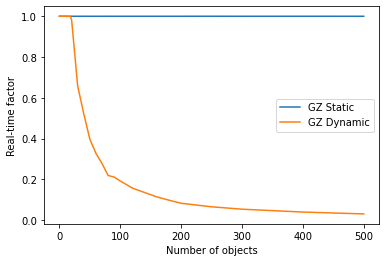

In [116]:
fig, ax = plt.subplots()
plt.plot(gazebo_static["count"], gazebo_static["RTF"], label="GZ Static")
plt.plot(gazebo_dynamic["count"], gazebo_dynamic["RTF"], label="GZ Dynamic")
plt.legend()
plt.ylabel("Real-time factor")
plt.xlabel("Number of objects")
plt.show()

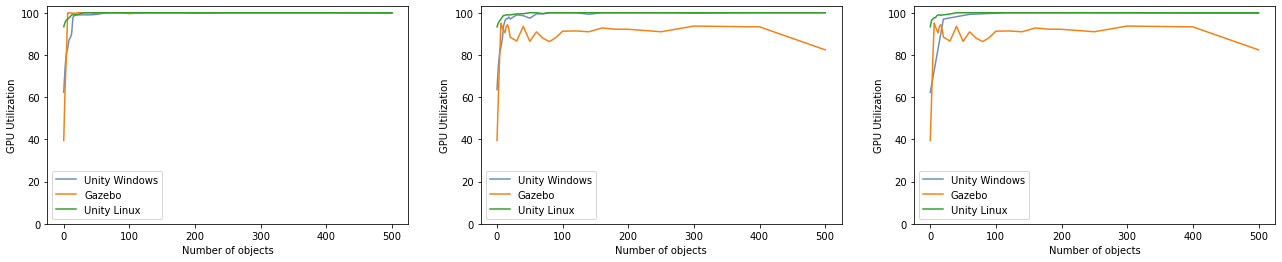

In [117]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["GPU"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["GPU"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["GPU"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["GPU"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["GPU"], label="Unity Linux")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("GPU Utilization")
    i.set_ylim(0)
    i.legend()
         
plt.show()

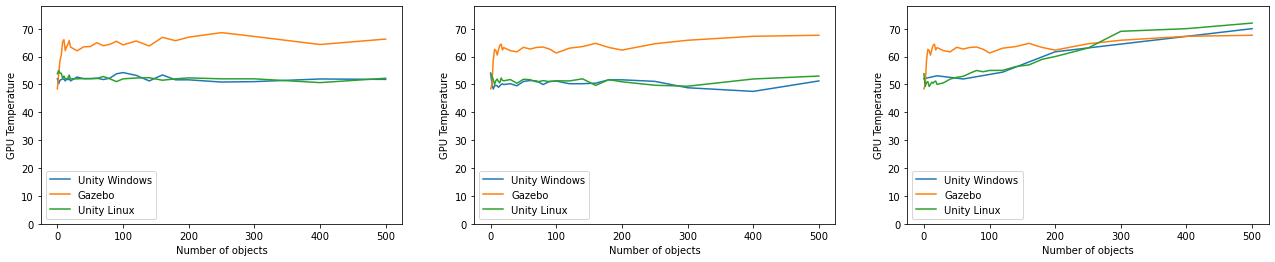

In [118]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["GPU_TEMP"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["GPU_TEMP"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["GPU_TEMP"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["GPU_TEMP"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["GPU_TEMP"], label="Unity Linux")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU_TEMP"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU_TEMP"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("GPU Temperature")
    i.set_ylim(0,78)
    i.legend()
         
plt.show()

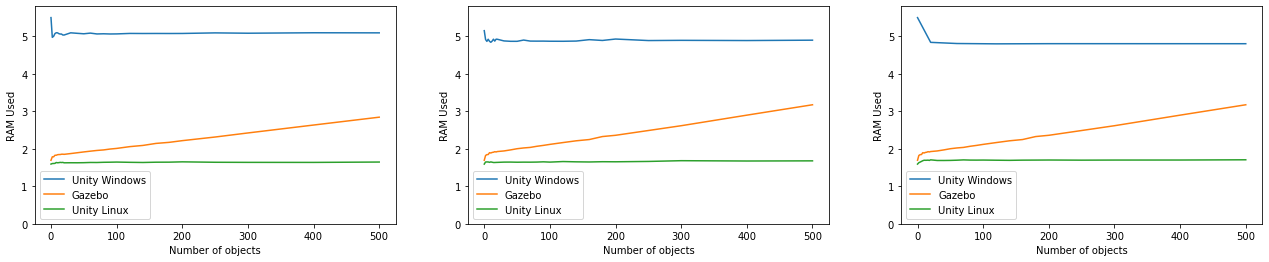

In [119]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["RAM_USED"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["RAM_USED"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["RAM_USED"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["RAM_USED"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["RAM_USED"], label="Unity Linux")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["RAM_USED"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["RAM_USED"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("RAM Used")
    i.set_ylim(0,5.8)
    i.legend()
         
plt.show()

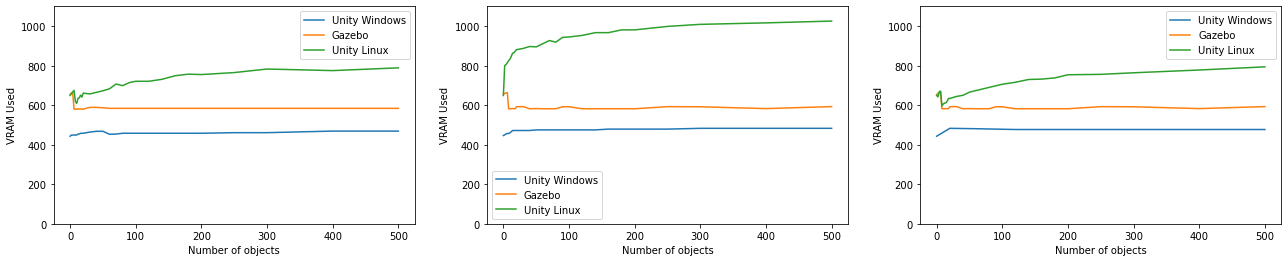

In [120]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["VRAM_USED"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["VRAM_USED"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["VRAM_USED"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["VRAM_USED"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["VRAM_USED"], label="Unity Linux")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["VRAM_USED"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["VRAM_USED"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("VRAM Used")
    i.set_ylim(0, 1100)
    i.legend()
         
plt.show()

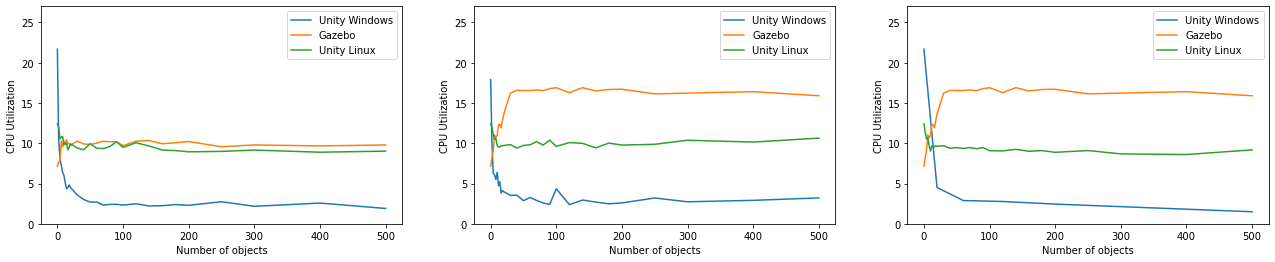

In [121]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["CPU_ALL"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["CPU_ALL"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["CPU_ALL"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["CPU_ALL"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["CPU_ALL"], label="Unity Linux")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["CPU_ALL"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["CPU_ALL"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("CPU Utilization")
    i.set_ylim(0,27)
    i.legend()
         
plt.show()

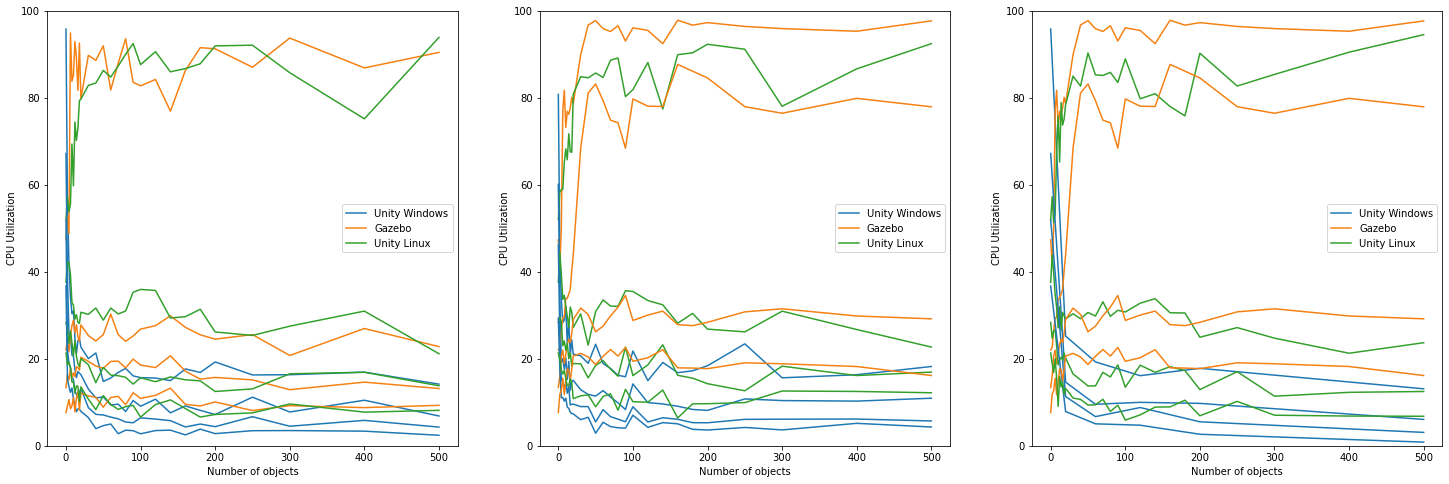

In [146]:
fig, ax = plt.subplots(1,3, figsize=(25, 8))

# First 4 cores
for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax[0].plot(unity_win_static["count"], unity_win_static[col_name], '#1f78b4')
    ax[0].plot(gazebo_static["count"], gazebo_static[col_name], '#f58113')
    ax[0].plot(unity_static["count"], unity_static[col_name], "#33a02c")

    ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic[col_name], '#1f78b4')
    ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], '#f58113')
    ax[1].plot(unity_dynamic["count"], unity_dynamic[col_name], "#33a02c")

    ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed[col_name], '#1f78b4')
    ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], '#f58113')
    ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed[col_name], "#33a02c")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("CPU Core Utilization")
    i.set_ylim(0,100)
    i.legend(["Unity Windows", "Gazebo", "Unity Linux"])
         
plt.show()

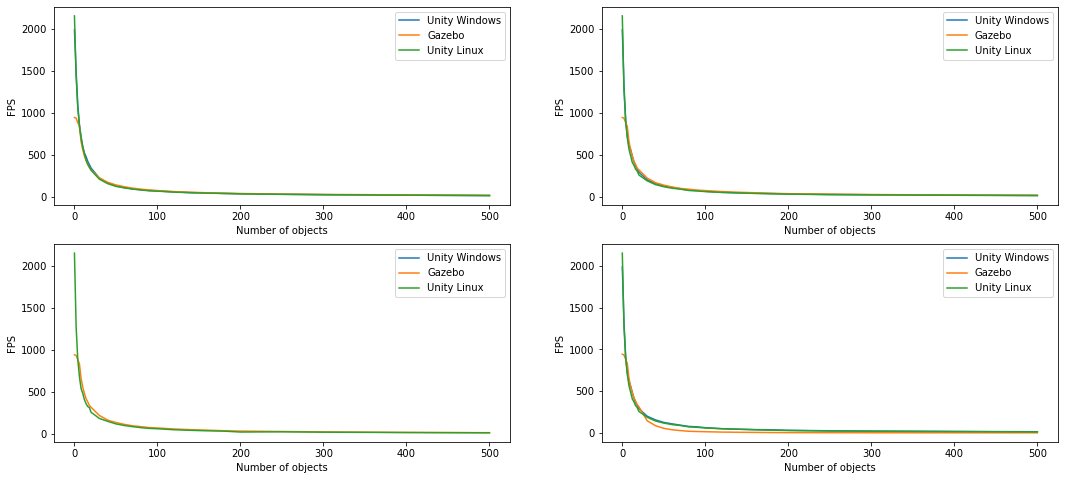

In [172]:
fig, ax = plt.subplots(2,2, figsize=(18, 8))

ax[0,0].plot(unity_win_static["count"], unity_win_static["FPS"], label="Unity Windows")
ax[0,0].plot(gazebo_static["count"], gazebo_static["FPS"], label="Gazebo")
ax[0,0].plot(unity_static["count"], unity_static["FPS"], label="Unity Linux")

ax[0,1].plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], label="Unity Windows")
ax[0,1].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], label="Gazebo")
ax[0,1].plot(unity_dynamic["count"], unity_dynamic["FPS"], label="Unity Linux")

ax[1,0].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["FPS"], label="Unity Windows")
ax[1,0].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], label="Gazebo")
ax[1,0].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["FPS"], label="Unity Linux")

ax[1,1].plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], label="Unity Windows")
ax[1,1].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_SCALED"], label="Gazebo")
ax[1,1].plot(unity_dynamic["count"], unity_dynamic["FPS"], label="Unity Linux")

for i in ax.flatten():
    i.set_xlabel("Number of objects")
    i.set_ylabel("FPS")
    # i.set_xlim(-5, 20)
    i.legend()
         
plt.show()

## 